In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
import torch as th
import torch.jit as jit
import numpy as np
from torch import optim
from torch import nn
from dynrn.rnntasks import DriscollTasks, itiexp
import dynrn.basic_rnns as rnns
import scipy.stats
from scipy.stats import uniform, norm
from datetime import datetime
from mplutil import util as vu
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm
import joblib as jl
import time
import seaborn as sns

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from dynrn.viz import styles
from dynrn.viz.styles import getc
t20 = lambda x: getc(f"seaborn:tab20{x}")
colors, plotter = styles.init_plt(
    '../plots/notebook/driscoll-rnns',
    fmt = 'pdf')
plot_root = Path(plotter.plot_dir)

In [4]:
# cuda setup
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
cpu = th.device('cpu' if th.cuda.is_available() else 'cpu')
print(device.type)

cuda


### Load RNN and get hidden trajectories

In [5]:
model_root = Path("/n/home08/kfox/sabalab/kfox/loop/dynrn/task-models")
# model_path = model_root / "driscoll-long-alpha1-n1024-test_5c0ae.07181038"
model_path = model_root / "driscoll-n1024_5c135.07181253"
train = jl.load(f"{model_path}.train.jl")
model = jit.load(f"{model_path}.pt")
model.load_state_dict(th.load(f"{model_path}.tar"))

task_kws = jl.load(model_root / '../tasks' / "memorypro-long.jl")

In [6]:
x, y, periods = DriscollTasks.memorypro(
    session_length=500,
    n_sessions=200,
    seed = 1,
    **task_kws
)
x = th.tensor(x, dtype=th.float32)
y = th.tensor(y, dtype=th.float32)

xval, yval, periodsval = DriscollTasks.memorypro(
    session_length=500,
    n_sessions=50,
    seed = 2,
    **task_kws
)
xv = th.tensor(xval, dtype=th.float32)
yv = th.tensor(yval, dtype=th.float32)

In [7]:
tofs = 1

h_init = th.zeros(x.shape[0], model.nh)
yhat, h = model.to(cpu).seq_forward(x, h_init)
xh = h[:, :-tofs].detach()
yh = h[:, tofs:].detach()


In [9]:
h_init = th.zeros(xv.shape[0], model.nh)
yhatv, hv = model.to(cpu).seq_forward(xv, h_init)
xhv = hv[:, :-tofs].detach()
yhv = hv[:, tofs:].detach()

In [10]:
mlp = nn.Sequential(
    nn.Linear(xh.shape[-1], xh.shape[-1] // 2),
    nn.Softplus(),
    nn.LayerNorm(xh.shape[-1] // 2),
    nn.Linear(xh.shape[-1] // 2, xh.shape[-1] // 4),
    nn.Softplus(),
    nn.Linear(xh.shape[-1] // 4, yh.shape[-1])
).to(device)
opt = optim.Adam(mlp.parameters(), lr=1e-3)

losses, yhats, ckpts = rnns.fit_ffn(
    mlp,
    xh.to(device),
    yh.to(device),
    opt,
    n_steps=5001,
    return_batches=None,
    checkpoint_every = 1000,
)

100%|██████████| 5001/5001 [02:42<00:00, 30.70it/s]


In [16]:
out_dir = Path(f"/n/home08/kfox/sabalab/kfox/loop/dynrn/predictors")
jl.dump({
    'ckpts': ckpts, 'losses': losses, 'yhats': yhats
}, out_dir / "ffn-memorypro-tmp.jl")

['/n/home08/kfox/sabalab/kfox/loop/dynrn/predictors/ffn-memorypro-tmp.jl']

In [24]:
plot_units = [0, 1]
# evaluate each model checkpoint and pull a few units
ckpt_yhats =  [m(xh).detach().numpy() for m in ckpts]
yhat_selected = sum([[yhat[..., plot_units]] + [None] * 999 for yhat in ckpt_yhats], [])
yh_selected = yh[..., plot_units]

yhatsv = [m(xhv).detach().cpu() for m in ckpts]
lossesv = [nn.MSELoss()(yhat, yhv) for yhat in yhatsv]

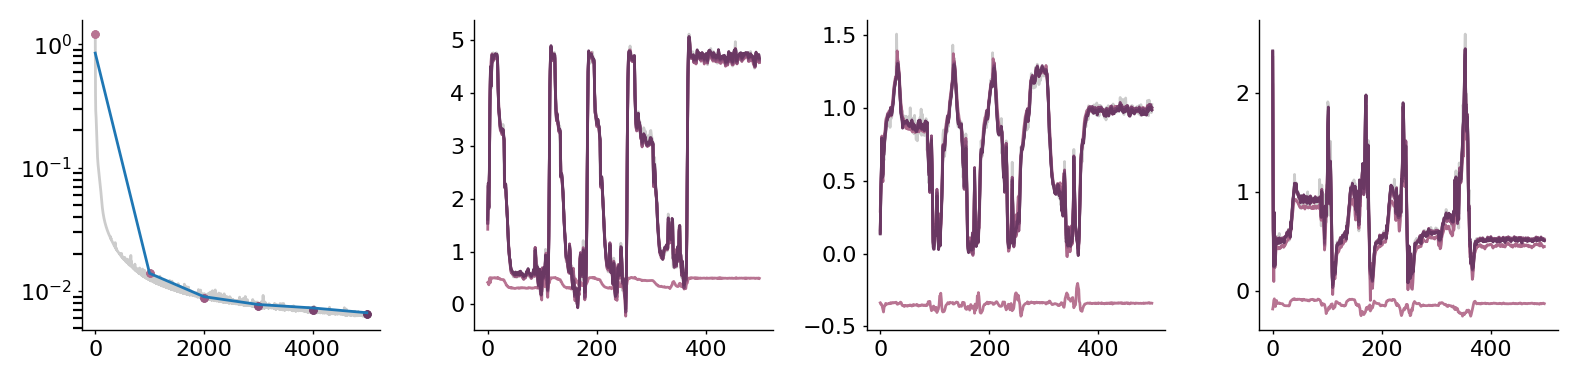

In [20]:
ts = np.arange(0, 5001, 1000)

fig, ax = rnns.plot_rnn_training(losses, yhat_selected, yh_selected, epochs = ts)
ax[0].set_yscale('log')
ax[0].plot(ts, lossesv, color = colors.C[0])
plotter.finalize(fig, None)

In [38]:
def plot_memorypro_prediction(
    losses, yhat_selected, yh_selected, losses_val, epochs, plot_units, session=0
):
    n_units = len(plot_units)
    fig, ax = plt.subplots(
        2,
        n_units + 1,
        figsize=(2 + 3 * n_units, 2),
        sharex="col",
        width_ratios=[1] + [2] * n_units,
    )
    rnns.plot_rnn_training(
        losses,
        yhat_selected,
        yh_selected,
        epochs=epochs,
        session=session,
        ax = ax[0, :]
    )

    ax[0, 0].set_yscale("log")
    ax[1, 0].set_axis_off()
    ax[0, 0].plot(epochs, losses_val, color = colors.neutral, zorder = -1)

    for r in range(2):
        for i in range(0, n_units):
            plot_driscoll_ax(
                ax[r, i + 1],
                x,
                y,
                periods,
                session=session,
                periods_only=not r,
            )
            if r == 1:
                ax[r, i + 1].twinx().plot(
                    xh[session, :, plot_units[i]],
                    color=colors.neutral,
                    lw=1,
                )

    return fig, ax

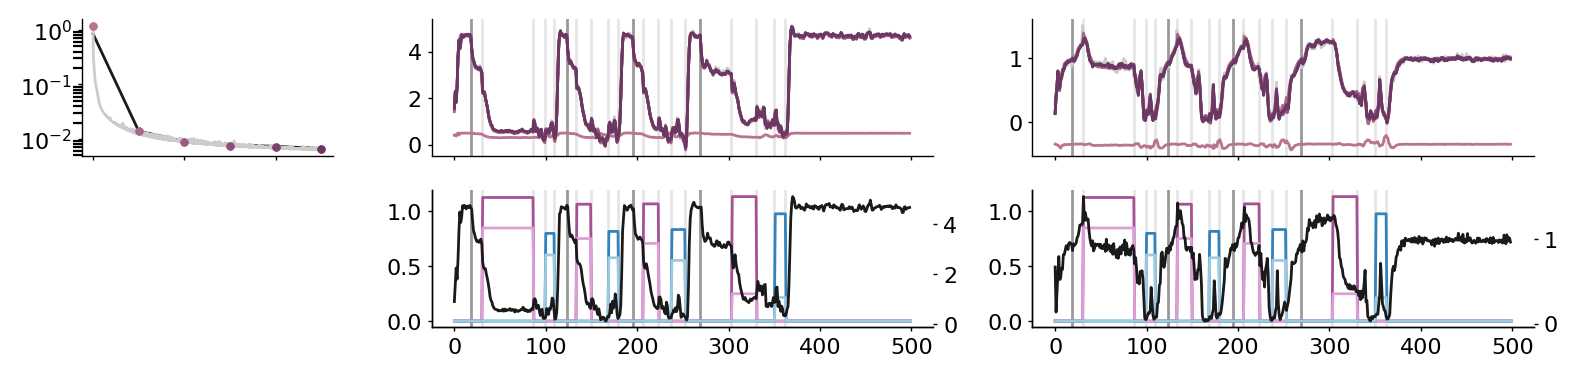

In [39]:

fig, ax = plot_memorypro_prediction(losses, yhat_selected, yh_selected, lossesv, ts, plot_units)

plotter.finalize(fig, None)

##### without batchnorm
Hard to deal with in sign-constained models. Does this training work without it?

Spoiler: it does.

In [28]:
mlp = nn.Sequential(
    nn.Linear(xh.shape[-1], xh.shape[-1] // 2),
    nn.Softplus(),
    nn.Linear(xh.shape[-1] // 2, xh.shape[-1] // 4),
    nn.Softplus(),
    nn.Linear(xh.shape[-1] // 4, yh.shape[-1])
).to(device)
opt = optim.Adam(mlp.parameters(), lr=1e-3)

losses, yhats, ckpts = rnns.fit_ffn(
    mlp,
    xh.to(device),
    yh.to(device),
    opt,
    n_steps=5001,
    return_batches=None,
    checkpoint_every = 1000,
)

100%|██████████| 5001/5001 [00:57<00:00, 86.95it/s]


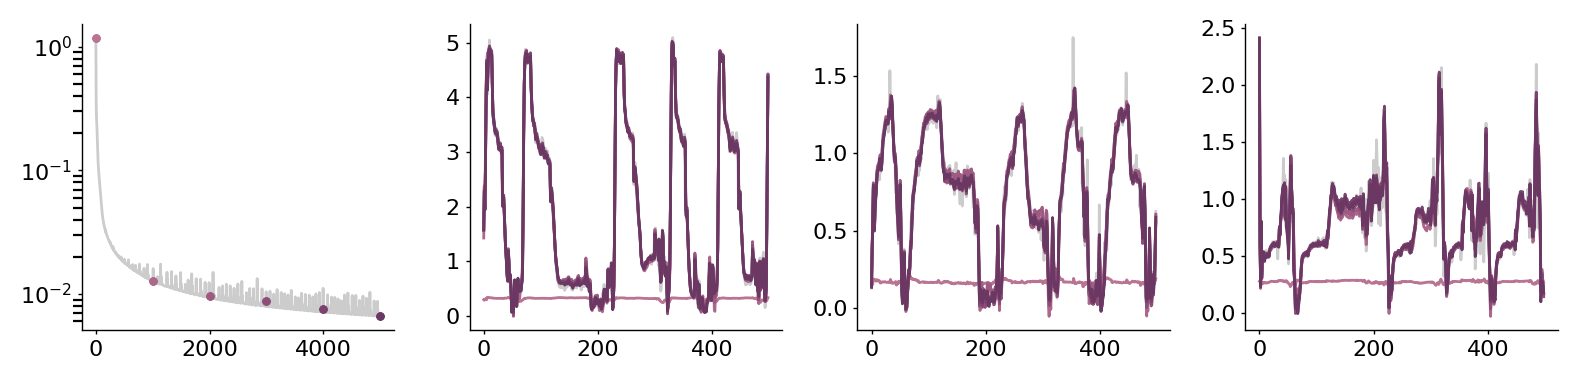

In [29]:
plot_units = [0, 1, 2]

# evaluate each model checkpoint and pull a few units
ckpt_yhats =  [m(xh).detach().numpy() for m in ckpts]
yhat_selected = sum([[yhat[..., plot_units]] + [None] * 999 for yhat in ckpt_yhats], [])
yh_selected = yh[..., plot_units]

fig, ax = rnns.plot_rnn_training(losses, yhat_selected, yh_selected, epochs = range(0, 5001, 1000))
ax[0].set_yscale('log')
plotter.finalize(fig, None)

##### longer $t_{\text{ofs}}$

$t_{\text{ofs}} = 10$ 

In [31]:

tofs = 10
xh = h[:, :-tofs].detach()
yh = h[:, tofs:].detach()


In [32]:
mlp = nn.Sequential(
    nn.Linear(xh.shape[-1], xh.shape[-1] // 2),
    nn.Softplus(),
    nn.Linear(xh.shape[-1] // 2, xh.shape[-1] // 4),
    nn.Softplus(),
    nn.Linear(xh.shape[-1] // 4, yh.shape[-1])
).to(device)
opt = optim.Adam(mlp.parameters(), lr=1e-3)

losses, yhats, ckpts = rnns.fit_ffn(
    mlp,
    xh.to(device),
    yh.to(device),
    opt,
    n_steps=5001,
    return_batches=None,
    checkpoint_every = 1000,
)

100%|██████████| 5001/5001 [00:56<00:00, 87.74it/s]


In [22]:
def plot_driscoll_ax(ax, x, y, periods, t = None, session = 0, periods_only = False):
    icolors = [getc("k"), getc("grey"), t20("b:17"), t20("b:19")]
    ocolors = [t20("c:0"), t20("c:2")]
    if t is None:
        t = np.arange(x.shape[1])

    if not periods_only:
        # ax.plot(t, x.numpy()[session, :, 0], color = icolors[0], lw = 0.5, alpha = 0.3)
        # ax.plot(t, x.numpy()[session, :, 1], color = icolors[1], lw = 0.5, alpha = 0.3)
        ax.plot(t, x.numpy()[session, :, 2], color = icolors[2], lw = 1)
        ax.plot(t, x.numpy()[session, :, 3], color = icolors[3], lw = 1)
        ax.plot(t, y.numpy()[session, :, 0], color = ocolors[0], lw = 1)
        ax.plot(t, y.numpy()[session, :, 1], color = ocolors[1], lw = 1)
    for i in np.where(np.diff(periods[session]) != 0)[0]:
        ax.axvline(t[i], color='.6' if periods[session, i] == 0 else '.9', lw = 1, zorder = -1)


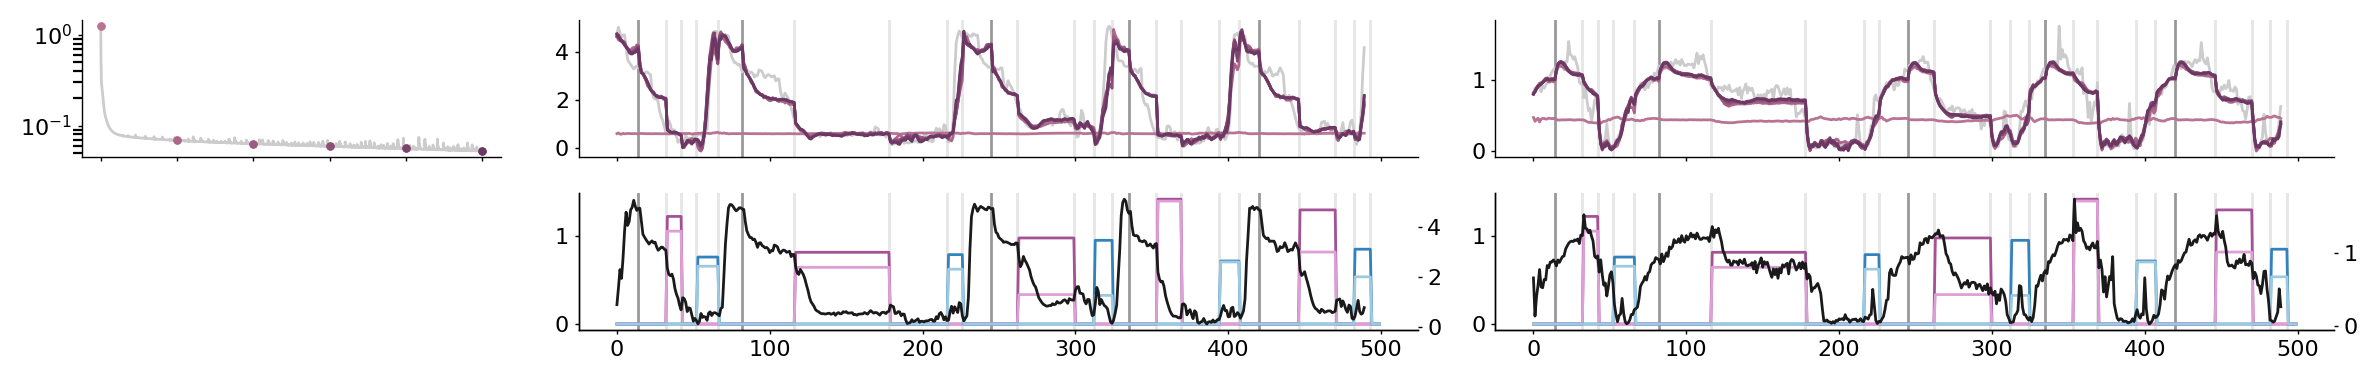

In [65]:
plot_units = [0, 1]

fig, ax = plt.subplots(2, len(plot_units) + 1, figsize=(12, 2), sharex="col", width_ratios = [1] + [2] * len(plot_units))

# evaluate each model checkpoint and pull a few units
ckpt_yhats = [m(xh).detach().numpy() for m in ckpts]
yhat_selected = sum([[yhat[..., plot_units]] + [None] * 999 for yhat in ckpt_yhats], [])
yh_selected = yh[..., plot_units]

rnns.plot_rnn_training(
    losses, yhat_selected, yh_selected, epochs=range(0, 5001, 1000), ax=ax[0]
)
ax[0, 0].set_yscale("log")
ax[1, 0].set_axis_off()
for r in range(2):
    for i in range(0, len(plot_units)):
        plot_driscoll_ax(
            ax[r, i + 1],
            x,
            y,
            periods,
            t=np.arange(0, y.shape[1]),
            session=0,
            periods_only=not r,
        )
        if r == 1:
            ax[r, i + 1].twinx().plot(
                xh[0, :, plot_units[i]],
                color = colors.neutral,
                lw = 1,
            )



plotter.finalize(fig, None)

$t_{\text{ofs}} = 50$ 

In [66]:

tofs = 50
xh = h[:, :-tofs].detach()
yh = h[:, tofs:].detach()


In [67]:
mlp = nn.Sequential(
    nn.Linear(xh.shape[-1], xh.shape[-1] // 2),
    nn.Softplus(),
    nn.Linear(xh.shape[-1] // 2, xh.shape[-1] // 4),
    nn.Softplus(),
    nn.Linear(xh.shape[-1] // 4, yh.shape[-1])
).to(device)
opt = optim.Adam(mlp.parameters(), lr=1e-3)

losses, yhats, ckpts = rnns.fit_ffn(
    mlp,
    xh.to(device),
    yh.to(device),
    opt,
    n_steps=5001,
    return_batches=None,
    checkpoint_every = 1000,
)

  0%|          | 5/5001 [00:00<01:40, 49.86it/s]

100%|██████████| 5001/5001 [00:58<00:00, 85.92it/s]


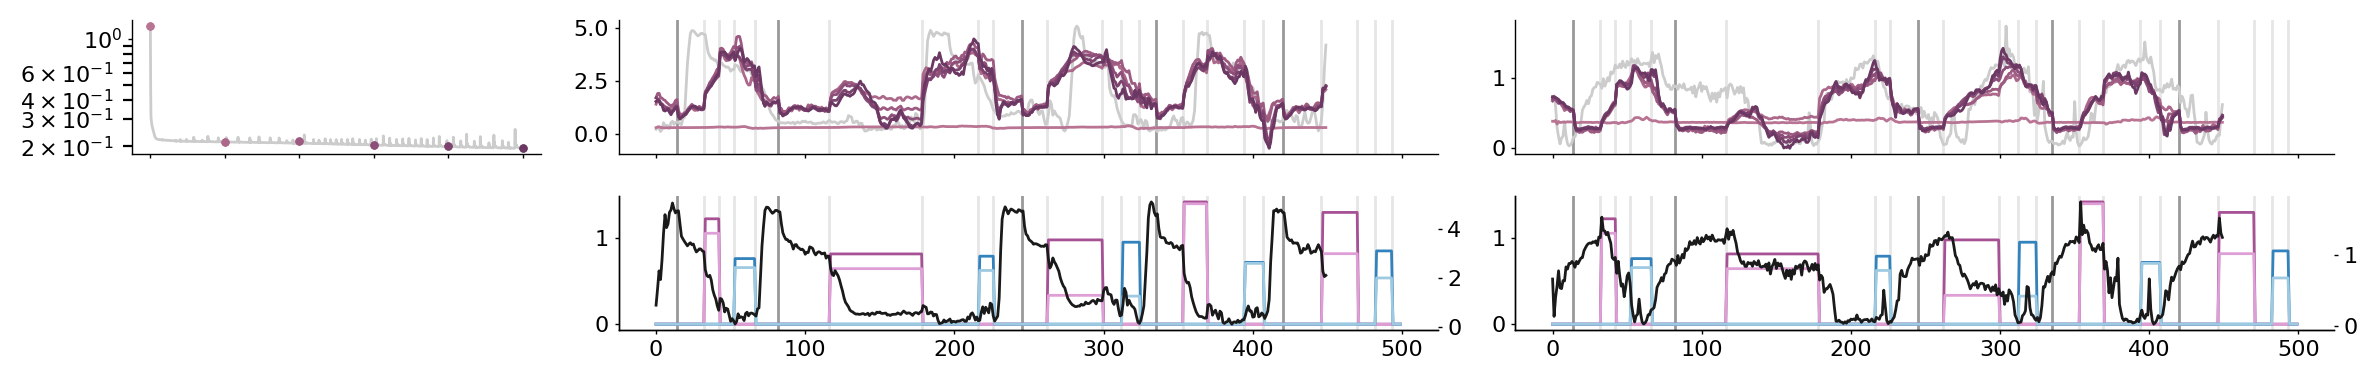

In [68]:
plot_units = [0, 1]

fig, ax = plt.subplots(2, len(plot_units) + 1, figsize=(12, 2), sharex="col", width_ratios = [1] + [2] * len(plot_units))

# evaluate each model checkpoint and pull a few units
ckpt_yhats = [m(xh).detach().numpy() for m in ckpts]
yhat_selected = sum([[yhat[..., plot_units]] + [None] * 999 for yhat in ckpt_yhats], [])
yh_selected = yh[..., plot_units]

rnns.plot_rnn_training(
    losses, yhat_selected, yh_selected, epochs=range(0, 5001, 1000), ax=ax[0]
)
ax[0, 0].set_yscale("log")
ax[1, 0].set_axis_off()
for r in range(2):
    for i in range(0, len(plot_units)):
        plot_driscoll_ax(
            ax[r, i + 1],
            x,
            y,
            periods,
            t=np.arange(0, y.shape[1]),
            session=0,
            periods_only=not r,
        )
        if r == 1:
            ax[r, i + 1].twinx().plot(
                xh[0, :, plot_units[i]],
                color = colors.neutral,
                lw = 1,
            )



plotter.finalize(fig, None)